# Low-Rank RNN

Discrete RNN :

$$
\dot h_i(t) = -h_i(t) + \sum_j J_{ij} \phi(h_j(t)) + I^{\mathrm{ext}}_i(t) \\
J_{ij} = \sum_{\mu=1}^p f_\mu(\vec{z_i}) g_\mu(\vec{z_j})
$$

Neural field equations :

$$
\dot h(t, \vec z) = -h(t, \vec z) + \int \rho(\vec y) \sum_{\mu=1}^p f_\mu(\vec{z}) g_\mu(\vec{z}) \phi(h(t, \vec y)) \; \mathrm d y
$$

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from neurodyn import *

### Optimal einsum path

first do the sum on the patterns, then on the neurons

In [3]:
params = LowRankRNNParams.new_valentin(p=1, N=10_000_000, phi=sigmoid, I_ext=zero, exclude_self_connections=True)
F, G = params.F, params.G
rate = sigmoid(F[:, 0])

# main sum
path_info = np.einsum_path('im,jm,j->i', F, G, rate, optimize='optimal')
print(path_info[0])
print(path_info[1])

# removing self-connections
path_info = np.einsum_path('im,im,i->i', F, G, rate, optimize='optimal')
print(path_info[0])
print(path_info[1])

['einsum_path', (1, 2), (0, 1)]
  Complete contraction:  im,jm,j->i
         Naive scaling:  3
     Optimized scaling:  2
      Naive FLOP count:  3.000e+14
  Optimized FLOP count:  4.000e+07
   Theoretical speedup:  7499999.813
  Largest intermediate:  1.000e+07 elements
--------------------------------------------------------------------------
scaling                  current                                remaining
--------------------------------------------------------------------------
   2                     j,jm->m                                  im,m->i
   2                     m,im->i                                     i->i
['einsum_path', (0, 1), (0, 1)]
  Complete contraction:  im,im,i->i
         Naive scaling:  2
     Optimized scaling:  2
      Naive FLOP count:  3.000e+07
  Optimized FLOP count:  3.000e+07
   Theoretical speedup:  1.000
  Largest intermediate:  1.000e+07 elements
--------------------------------------------------------------------------
scaling      

## Ensure the low-rank formulation is the same as the explicit connectivity matrix

[-2.28  3.78  4.23  2.71  2.48 -3.44  0.11  0.82  2.66  3.12 -1.84  3.25
  1.7   2.61 -4.85  1.14]
[-2.28  3.78  4.23  2.71  2.48 -3.44  0.11  0.82  2.66  3.12 -1.84  3.25
  1.7   2.61 -4.85  1.14]


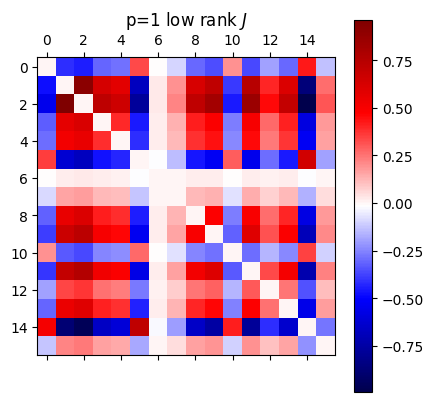

In [4]:
N = 16
params = LowRankRNNParams.new_valentin(p=1, N=N, phi=sigmoid, I_ext=zero, exclude_self_connections=True)
F, G = params.F, params.G
J = params.to_dense().J

with np.printoptions(precision=2, suppress=True, threshold=80):
	rate = sigmoid(F[:, 0])
	print(J @ rate)
	drive = np.zeros_like(rate)
	drive += np.einsum('im,jm,j->i', F, G, rate)
	drive -= np.einsum('im,im,i->i', F, G, rate)
	drive /= N
	print(drive)

im = plt.matshow(J, cmap='seismic')
plt.colorbar(im)
plt.title('p=1 low rank $J$')
plt.show()

simulating DenseRNN{N=64, phi=sigmoid, I_ext=zero, exclude_self_connections=True}: 100.00%|██████████| t=10.000 of 10 [00:00<00:00]
simulating LowRankRNN{N=64, p=1, phi=sigmoid, I_ext=zero, exclude_self_connections=True}: 100.00%|██████████| t=10.000 of 10 [00:00<00:00]


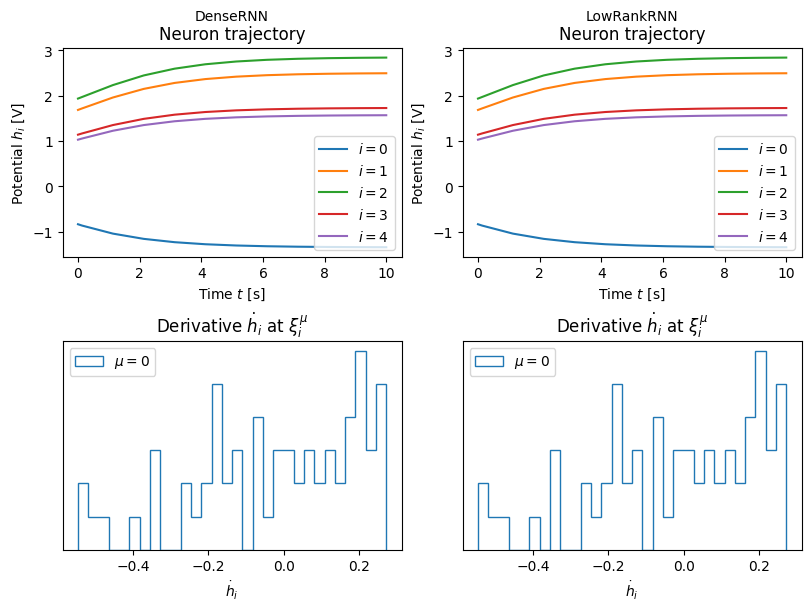

simulating DenseRNN{N=128, phi=sigmoid, I_ext=zero, exclude_self_connections=True}: 100.00%|██████████| t=10.000 of 10 [00:00<00:00]
simulating LowRankRNN{N=128, p=1, phi=sigmoid, I_ext=zero, exclude_self_connections=True}: 100.00%|██████████| t=10.000 of 10 [00:00<00:00]


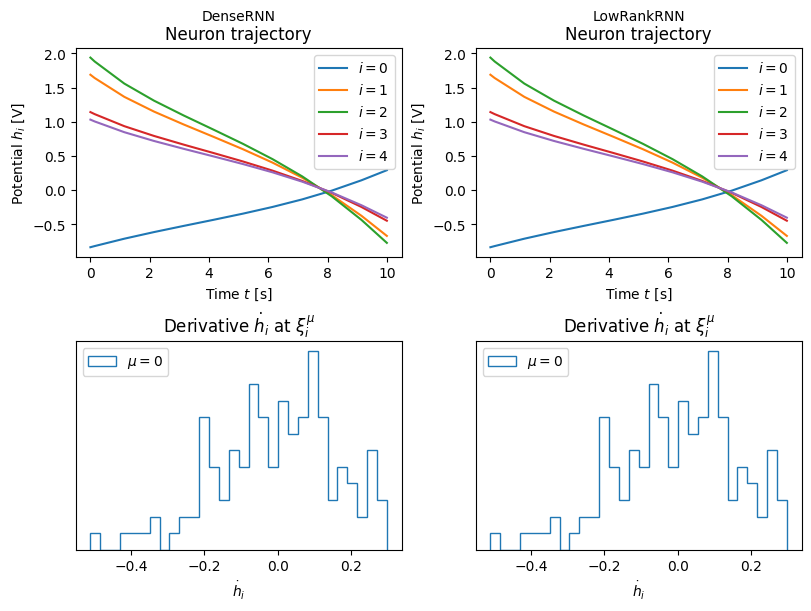

simulating DenseRNN{N=256, phi=sigmoid, I_ext=zero, exclude_self_connections=True}: 100.00%|██████████| t=10.000 of 10 [00:00<00:00]
simulating LowRankRNN{N=256, p=1, phi=sigmoid, I_ext=zero, exclude_self_connections=True}: 100.00%|██████████| t=10.000 of 10 [00:00<00:00]


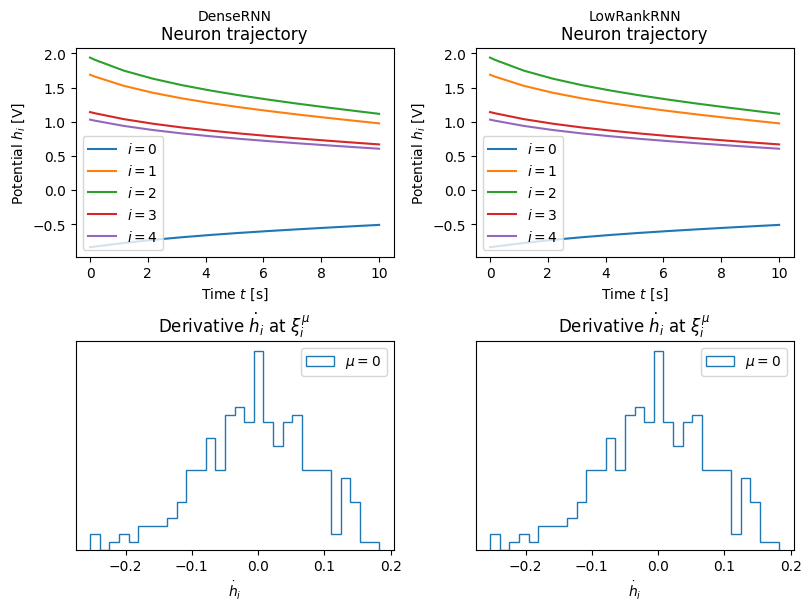

simulating DenseRNN{N=512, phi=sigmoid, I_ext=zero, exclude_self_connections=True}: 100.00%|██████████| t=10.000 of 10 [00:00<00:00]
simulating LowRankRNN{N=512, p=1, phi=sigmoid, I_ext=zero, exclude_self_connections=True}: 100.00%|██████████| t=10.000 of 10 [00:00<00:00]


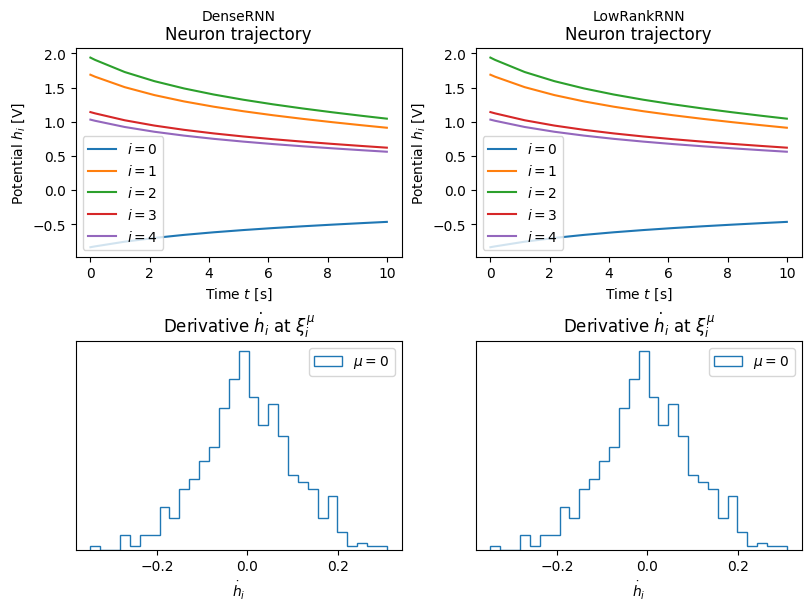

In [5]:
for N in [64, 128, 256, 512]:
	rnn_lr = LowRankRNN.new_valentin(p=1, N=N, phi=sigmoid, I_ext=zero, exclude_self_connections=True)
	rnn_dense = DenseRNN(rnn_lr.params.to_dense())
	
	res_full = rnn_dense.simulate(h0=rnn_lr.F[:, 0], t_span=(0, 10), dt_max=1, progress=True)
	res_lr = rnn_lr.simulate(h0=rnn_lr.F[:, 0], t_span=(0, 10), dt_max=1, progress=True)

	fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(8, 6), layout='constrained')
	rnn_dense.F = rnn_lr.F  # HACK : get the dh hist plot to work
	plot_neuron_trajectory(res_full, figax=(fig, ax[0, 0]))
	plot_neuron_trajectory(res_lr, figax=(fig, ax[0, 1]))
	plot_dh_hist(rnn_dense, figax=(fig, ax[1, 0]))
	plot_dh_hist(rnn_lr, figax=(fig, ax[1, 1]))
	add_headers(fig, col_headers=['DenseRNN', 'LowRankRNN'], col_pad=20)
	plt.show()

## Are the $\vec{z_i}$ stationary points ?

simulating LowRankRNN{N=1000, p=1, phi=sigmoid, I_ext=zero, exclude_self_connections=True}: 100.00%|██████████| t=5.000 of 5 [00:00<00:00]
simulating LowRankRNN{N=5000, p=1, phi=sigmoid, I_ext=zero, exclude_self_connections=True}: 100.00%|██████████| t=5.000 of 5 [00:00<00:00]
simulating LowRankRNN{N=10000, p=1, phi=sigmoid, I_ext=zero, exclude_self_connections=True}: 100.00%|██████████| t=5.000 of 5 [00:00<00:00]
simulating LowRankRNN{N=50000, p=1, phi=sigmoid, I_ext=zero, exclude_self_connections=True}: 100.00%|██████████| t=5.000 of 5 [00:00<00:00]


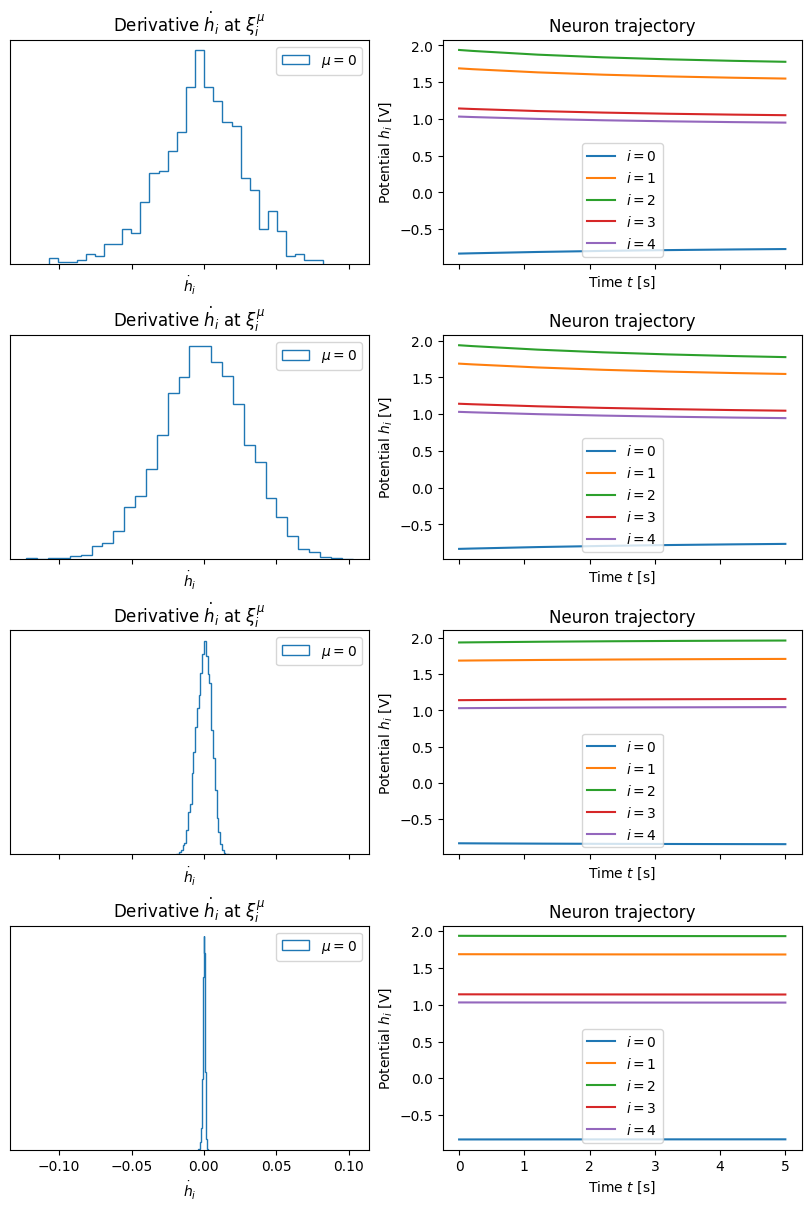

In [6]:
Ns = [1000, 5000, 10_000, 50_000]
fig, ax = plt.subplots(ncols=2, nrows=len(Ns), figsize=(8, 3*len(Ns)), sharex='col', constrained_layout=True)

for i, N in enumerate(Ns):
	rnn = LowRankRNN.new_valentin(p=1, N=N, phi=sigmoid, I_ext=zero, exclude_self_connections=True)
	res = rnn.simulate(h0=rnn.F[:, 0], t_span=(0, 5), dt_max=1, progress=True)
	plot_dh_hist(rnn, figax=(fig, ax[i, 0]))
	plot_neuron_trajectory(res, figax=(fig, ax[i, 1]))

plt.show()